In [4]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Rescaling
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, LayerNormalization
import tensorflow_addons as tfa
import pickle
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import L2
from keras.models import Model
import numpy
from sklearn.model_selection import train_test_split

# tf.enable_eager_execution()
# tf.executing_eagerly()
# tf.config.run_functions_eagerly(True)
import warnings

warnings.filterwarnings("ignore")

In [5]:
train_path = "./train"
test_path = "./test"


In [6]:
def process_data(img_dims, batch_size):
  train_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_gen = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
  )

  test_gen = test_datagen.flow_from_directory(
      directory=test_path,
      target_size=(img_dims, img_dims),
      batch_size=batch_size,
      class_mode='binary',
      shuffle=True
  )

  return (train_gen, test_gen)

In [7]:
img_dims = 160
epochs=100
batch_size=16

train_gen, test_gen = process_data(img_dims, batch_size)

Found 12134 images belonging to 2 classes.
Found 2615 images belonging to 2 classes.


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

tf.compat.v1.enable_eager_execution()

In [9]:
num_classes = 2
input_shape = (160, 160, 3)

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 100
image_size = 160  # We'll resize input images to this size
patch_size = 80  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
class Patches(layers.Layer):
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size,
        })
        return config

    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, batch_size, 80, 80, 3])
        print("patches.shape : ", patches.shape)
        return patches

In [13]:
class PatchEncoder(layers.Layer):
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding': self.position_embedding,
        })
        return config

    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        # self.projection = layers.Dense(units=projection_dim)

        regularizer = L2(l2=0.001)

        xception = Xception(input_shape=(80,80,3),weights='imagenet', include_top=False)

        for layer in xception.layers:
            layer.trainable = False

        x = Flatten()(xception.output)
        prediction = Dense(1024)(x)
        prediction = Dense(512)(prediction)
        prediction = Dense(256)(prediction)
        prediction = Dense(units=projection_dim)(prediction)

        model = Model(inputs=xception.input, outputs=prediction)

        self.projection = model
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        print("Patch.shape : ", patch.shape)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # finalOutput = 1
        # x = tf.unstack(patch)
        # for ind, p in enumerate(patch):
        #     print(p.shape)
        #     output = self.projection(patch)
        #     if (id>0):
        #       finalOutput = tf.concat([finalOutput, output], axis=0)
        #     if (id == 0):
        #       finalOutput=output
        encoded = CustomXception()(patch) + self.position_embedding(positions)

        return encoded

In [14]:
class CustomXception(layers.Layer):
  def __init__(self):
    super(CustomXception, self).__init__()
    regularizer = L2(l2=0.001)

    xception = Xception(input_shape=(80, 80, 3), weights='imagenet', include_top=False)

    for layer in xception.layers:
      layer.trainable = False
    
    x = Flatten()(xception.output)
    prediction = Dense(1024)(x)
    prediction = Dense(512)(prediction)
    prediction = Dense(256)(prediction)
    prediction = Dense(units=64)(prediction)

    model = Model(inputs=xception.input, outputs=prediction)
    self.model = Model

  def call(self, patches):
    print("inside custom xception layer : ", patches.shape)

    

    # outputs = tf.placeholder(tf.float32)
    finalOutput = 1

    for id, patch in enumerate(patches):
      print('inside custom layer for loop : ', patch.shape)
      print(patch)
      output = self.model(patch)
      if (id>0):
        finalOutput = tf.concat([finalOutput, output], axis=0)
      if (id == 0):
        finalOutput=output
      # outputs = tf.concat([outputs, output], axis=0)
    print(finalOutput)
    return finalOutput
      

In [15]:
X = []
y = []
# read the above pickled data
with open('X_encoded.pickle', 'rb') as f:
    X = pickle.load(f)
    
with open('y_encoded.pickle', 'rb') as f:
    y = pickle.load(f)

X = numpy.array(X)
y = numpy.array(y)
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

2022-06-20 13:34:19.940847: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-20 13:34:19.940869: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-20 13:34:19.940887: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dhiraj-Inspiron-5593): /proc/driver/nvidia/version does not exist
2022-06-20 13:34:19.941554: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(14749, 4, 64)
(14749,)


In [16]:
def create_vit_classifier():
    inputs = layers.Input(shape=((4,64)))
    # Create patches.
    # patches = Patches(patch_size)(inputs)

    # Encode patches.
    # encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(inputs)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, inputs])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(inputs)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [17]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'FalseNegatives', 'FalsePositives', 'Precision', 'Recall', 'TrueNegatives', 'TruePositives'],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)

    _, accuracy, FalseNegatives, FalsePositives, Precision, Recall, TrueNegatives, TruePositives = model.evaluate(X_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test FalseNegatives: {FalseNegatives}%")
    print(f"Test FalsePositives: {FalsePositives}%")
    print(f"Test Precision: {Precision}%")
    print(f"Test Recall: {Recall}%")
    print(f"Test TrueNegatives: {TrueNegatives}%")
    print(f"Test TruePositives: {TruePositives}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

2022-06-20 13:34:23.045378: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
738/738 [==============================] - 11s 14ms/step - loss: 0.7333 - accuracy: 0.5281 - false_negatives: 1801.0000 - false_positives: 3767.0000 - precision: 0.5629 - recall: 0.7293 - true_negatives: 1380.0000 - true_positives: 4851.0000 - val_loss: 0.6854 - val_accuracy: 0.5637 - val_false_negatives: 0.0000e+00 - val_false_positives: 1287.0000 - val_precision: 0.5637 - val_recall: 1.0000 - val_true_negatives: 0.0000e+00 - val_true_positives: 1663.0000
Epoch 2/100
738/738 [==============================] - 10s 14ms/step - loss: 0.6930 - accuracy: 0.5472 - false_negatives: 935.0000 - false_positives: 4408.0000 - precision: 0.5646 - recall: 0.8594 - true_negatives: 739.0000 - true_positives: 5717.0000 - val_loss: 0.6851 - val_accuracy: 0.5637 - val_false_negatives: 0.0000e+00 - val_false_positives: 1287.0000 - val_precision: 0.5637 - val_recall: 1.0000 - val_true_negatives: 0.0000e+00 - val_true_positives: 1663.0000
Epoch 3/100
738/738 [==============================] - 1

In [18]:
vit_classifier.save("xception-vit.h5")

In [19]:
with open('xception-vit_hist.pkl', 'wb') as f:
  pickle.dump(history.history, f)

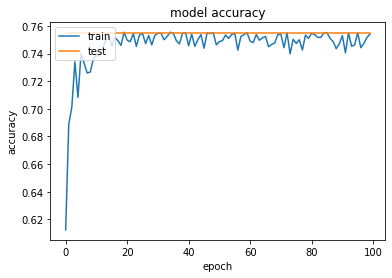

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.canvas.draw()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
labels = ['0.60', '0.62','0.64', '0.66', '0.68', '0.70', '0.72', '0.74', '0.76']
# plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_yticklabels(labels)
ax.legend(['train', 'test'], loc='upper left')
plt.show()

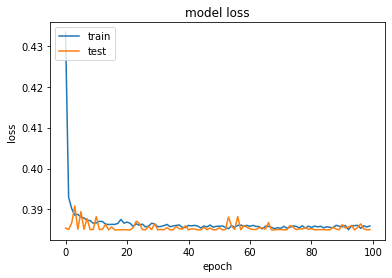

In [27]:
fig, ax = plt.subplots()
fig.canvas.draw()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
labels = ['0.38', '0.39','0.40', '0.41', '0.42', '0.43']
# plt.xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(labels)
ax.legend(['train', 'test'], loc='upper left')
plt.show()